# Desarrollo de Modelos Analíticos (Machine Learning)

#### Curso: K5551
#### Profesor: Ing. Sebastián Barbone
#### Alumno: Santiago Balbiani


### Class 2 - Business Understanding

#### Take only clients with 9 Months of Data. Why?
#### Take only clients without Active Package. Be careful with the month!

In [4]:
#Why only 9 months? Because te information provided by the business has only 9 months
# The month for getting the Clients without Active Package is January 2019, because is the last month before the Lead Window.
# Before the Lead Window, we are in the past. That means that the last month of the past (which is 1 month before the lead window)
# has the latest state of the clients, this is why we are interested in using January 2019 for knowing if the client doesn't have an active package.

#          _________________________________
#Apr 2019 |   Prediction Window             |   
#Mar 2019 |_________________________________|
#Feb 2019 |___Lead Window___________________|
#Jan 2019 |                                 |--> Jan is the last known state of clients
#Dec 2018 |                                 |
#Nov 2018 |   Training Window               |
#Oct 2018 |                                 |
#Sep 2018 |                                 |
#Ago 2018 |_________________________________|

# Un Dataset es balanceado si: 50% target - 50% non-Target
# Tecnicas de sampling implican por ejemplo reducir la cantidad de non-target para balancear el dataset en base a las constraints del negocio
# Otra técnica llamada oversampling es duplicar el target para balancear un poco mas el dataset.

import pandas as pd
import numpy as np
customers_all = pd.read_csv('data.csv', delimiter='|')
print('All clients data')
print(customers_all.shape)
#print(customers_all.Month.value_counts()) #26547 OK
#groupby('columnName')['ColumnToOperate'].lambdaFunction()
#lambdaFunction can be sum or count, for example. It will use the data of 'ColumnToOperate'
#with reset_index() you can reset the internal counter
#A grouping always involves a calculation like sum or count

customers_groupedByMonth = customers_all.groupby('client_id')['Month'].count().reset_index()
print('Clients grouped by number of months')
print(customers_groupedByMonth.shape)

#The [['client_id']] avoids to have 2 fields for Month, Month_x and Month_y, and discards the customers_groupedByMonth.Month.
customers_9MonthsHistory = customers_all.merge(customers_groupedByMonth[customers_groupedByMonth.Month == 9][['client_id']], how='inner', on='client_id')
print('Clients with 9 months of Data')
print(customers_9MonthsHistory.shape)

#   Clientes que no tienen tarjeta co-branding en enero de 2019
clients_without_coBranding_jan2019 = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['CreditCard_CoBranding'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])
print('Clients without co-branding from January 2019')
print(clients_without_coBranding_jan2019.shape)

#   Clientes que no tienen paquete en enero de 2019, Porque es lo que queremos vender y elegimos enero 2019 porque es 
#  el último mes antes del lead window.
Clients_without_package_jan2019 = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['Package_Active'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])
print('Clients without Package from January 2019')
print(Clients_without_package_jan2019.shape)

#   Nuestro Universo: Solo clientes con historial completo de 9 meses, que no tienen tarjeta cobranding en enero de 2019 
#    y no tienen paquete en enero de 2019.
print('\n')
print('Starting to filter the customers database to obtain our Universe Customers Data...')
print('\n')

customer_universe = pd.merge(left=customers_all,right=customers_9MonthsHistory['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 1: Only the registries of clients that have 9 months')
print(customer_universe.shape)

customer_universe = pd.merge(left=customer_universe,right=clients_without_coBranding_jan2019['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 2: Only those clients from Filter 1 that don t have co-branding from January 2019')
print(customer_universe.shape)

customer_universe = pd.merge(left=customer_universe,right=Clients_without_package_jan2019['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 3: Only those clients from Filter 2 that don t have a package from January 2019.\nFinal Customer Universe Data:')
print(customer_universe.shape)

customers_universe_ids = customer_universe.drop_duplicates(['client_id'])
print('Number of Clients from the Customer Universe Data')
print(customers_universe_ids.shape)

print('\n')
print('Starting to filter the customer Universe to obtain our Target Data...')
print('\n')

# Since we defined the last 2 months as target, we begin there:
universe_data_last_2_months = customer_universe[(customer_universe.Month == '2019-04-01') | (customer_universe.Month == '2019-03-01')].copy()
print('Target Filter 1: Last 2 months of Customers Universe Data')
print(universe_data_last_2_months.shape)

# From the last 2 months data, filter those that are marked as target
target_customers_data = universe_data_last_2_months[universe_data_last_2_months['Target'] == 1]
print('Target Filter 2: Data from previous filter but only those marked as Target')
print(target_customers_data.shape)

# Target Clients
clients_target = target_customers_data[['client_id']].drop_duplicates(['client_id'])
print('Target Filter 3: Get the clients from previous data')
print(clients_target.shape)

# Building the DataFrame Target vs NonTarget from the Universe
clients_target['TGT'] = 1
customers_universe_ids = customers_universe_ids.merge(clients_target[['client_id', 'TGT']], how='left', on='client_id')

#Filling NaN with Zero
customers_universe_ids['TGT'] = customers_universe_ids.TGT.fillna(0)


All clients data
(238615, 77)
Clients grouped by number of months
(26560, 2)
Clients with 9 months of Data
(238347, 77)
Clients without co-branding from January 2019
(23660, 2)
Clients without Package from January 2019
(26026, 2)


Starting to filter the customers database to obtain our Universe Customers Data...


Filter 1: Only the registries of clients that have 9 months
(2145123, 77)
Filter 2: Only those clients from Filter 1 that don t have co-branding from January 2019
(1915326, 77)
Filter 3: Only those clients from Filter 2 that don t have a package from January 2019.
Final Customer Universe Data:
(1878471, 77)
Number of Clients from the Customer Universe Data
(23191, 77)


Starting to filter the customer Universe to obtain our Target Data...


Target Filter 1: Last 2 months of Customers Universe Data
(417438, 77)
Target Filter 2: Data from previous filter but only those marked as Target
(122814, 77)
Target Filter 3: Get the clients from previous data
(6823, 1)


### Class 2 - Result: Universe and Target

In [5]:
print('Total Universe: ', str(len(customers_universe_ids)))
print('Universe Target / Non-Target distribution:')
print(customers_universe_ids[['TGT']].value_counts())

Total Universe:  23191
Universe Target / Non-Target distribution:
TGT
0.0    16368
1.0     6823
Name: count, dtype: int64


### Class 3 - Preprocessing and Transformation

In [6]:
#Notes:
# ABT - Analytic Base Table: Es una tabla que, partiendo de todas las Data Sources, te genera un registro por cliente.

# Data Types
# - Text: e.g. "The service is really bad" --> finding "bad" in a text = 1 point, otherwise, 0 point - Add column to BT with average points
# - Numerical: Integer, Float, Binary.
# - Categorical: Text that represent a category. e.g. "Product Type", "Regions", "Study Level".
# - Dates: They can let you get another values. e.g. "Antiguity", "age"

# Features: 
# - Identity Features: Variables directly used in the BT. e.g. "Age". They are taken from the last month of Training Window.
# - Trasnform Features: It uses a logic for transforming. e.g. "Study Level", "Client age groups"
# - Aggreate Features: Applies function/s to a Feature ranging a certaing time frame. 
    #Variables added based in a variable/s that represents a time frame. e.g. "Account Balance in 3 last 3 months"
    # e.g.2: Using CreditCard_Premiun for creating qty_months_with_creditCard_Premiun

# Dealing with Missing Values
# - Numericals: Delete the row/column or complete with zero or average, depending on the case.
# TIP: df.columns[df.isnull().any()].tolist()

# Use Case: 
# - Find Data Types from Data Sources
# - Find Transform Features
# - Find possible Transform Features(ordinal Features)
# - Find Identity Features
# - Create a DF with Identity and Transform Features
# - Find Missing Values and fill them

##  excluir registros de ultimos 3 meses (Lead window + prediction)
##  tratamiento de nulos como hacer en cada caso ==> por lo menos en variables Region y CreditCard_Product
##  hacer tratamiento de outliers.
##      moda: valor q mas se repite
##      mediana: ordenada de menor a mayor, la mitad del dataset

#train_data = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['Package_Active'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])

#len(train_data.client_id.unique()) 

#### 3.1 Identity Features
Age Group, Loan Active, Mortgage Active, Sex, Region

In [7]:
# Remember the Identity Features are taken from the last month of the Training Window

customer_universe_backup = pd.DataFrame(customer_universe)


identity_features = pd.DataFrame(customer_universe, columns = ['client_id', 'Client_Age_grp', 
                                                                                'Sex', 'Region', 'Mobile', 'Operations_Mobile', 
                                                                                'Investment_Numbers',
                                                                               'Loan_Active', 'CreditCard_Active',
                                                                               'Mortgage_Active', 'SavingAccount_Active_ARG',
                                                                               'SavingAccount_Active_DOLLAR', 'DebitCard_Active',
                                                                               'Investment_Active'])


identity_features = identity_features.drop_duplicates(['client_id'])

# We remove those fields from the Universe
customer_universe.drop(['Client_Age_grp', 'Sex', 
                        'Region', 'Mobile', 'Operations_Mobile', 
                        'Investment_Numbers',
                        'Loan_Active', 'CreditCard_Active',
                        'Mortgage_Active', 'SavingAccount_Active_ARG',
                        'SavingAccount_Active_DOLLAR', 'DebitCard_Active',
                        'Investment_Active'], axis=1, inplace=True)


#### 3.2 Transform Features
- Client_Age_grp 
- IsMobile_User 
- Inversor_Level 

In [8]:
identity_features.Client_Age_grp.value_counts()

Client_Age_grp
Entre 40 y 49 años    6463
Entre 30 y 39 años    5551
Entre 50 y 59 años    5121
Entre 60 y 64 años    2041
Entre 65 y 69 años    1669
Mayor a 70 años       1174
Entre 18 y 29 años    1172
Name: count, dtype: int64

In [9]:
# Transforming a Text into an ordinal variable
age_map = {
'Entre 18 y 29 años':1, 
'Entre 40 y 49 años':2,    
'Entre 30 y 39 años':3,    
'Entre 50 y 59 años':4,    
'Entre 60 y 64 años':5,    
'Entre 65 y 69 años':6,  
'Mayor a 70 años':7        
}

identity_features['Client_Age_grp_ord'] = identity_features['Client_Age_grp'].map(age_map)

identity_features.Client_Age_grp_ord.value_counts()

Client_Age_grp_ord
2    6463
3    5551
4    5121
5    2041
6    1669
7    1174
1    1172
Name: count, dtype: int64

In [10]:


def isMobileUser(x):
    if(x['Mobile'] == 'Yes' and x['Operations_Mobile'] > 10):
        return True
    return False

def inversorLevel(x):
    if(x['Investment_Numbers'] == 0):
        return 0
    elif(x['Investment_Numbers'] >= 1 and x['Investment_Numbers'] <= 2):
        return 1
    elif(x['Investment_Numbers'] >= 3 and x['Investment_Numbers'] <= 6):
        return 2
    elif(x['Investment_Numbers'] >= 7):
        return 3

identity_features['IsMobile_User'] = identity_features.apply(isMobileUser, axis=1)
identity_features['Inversor_Level'] = identity_features.apply(inversorLevel,axis=1)
identity_features['Active_Products'] =  (np.where(identity_features.Loan_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.CreditCard_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.Mortgage_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.SavingAccount_Active_ARG == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.SavingAccount_Active_DOLLAR == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.DebitCard_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.Investment_Active == 'Yes', 1, 0))  


print(identity_features.shape)

(23191, 18)


#### 3.3 Missing Data in Identity

In [11]:
identity_features.columns

Index(['client_id', 'Client_Age_grp', 'Sex', 'Region', 'Mobile',
       'Operations_Mobile', 'Investment_Numbers', 'Loan_Active',
       'CreditCard_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG',
       'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active',
       'Client_Age_grp_ord', 'IsMobile_User', 'Inversor_Level',
       'Active_Products'],
      dtype='object')

In [12]:
identity_features.columns[identity_features.isnull().any()].tolist()

['Region']

In [13]:
import math

def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

identity_features.loc[identity_features['Region'].isnull(),'Region_is_NaN'] = 'Yes'
identity_features.loc[identity_features['Region'].notnull(), 'Region_is_NaN'] = 'No'
identity_features.Region_is_NaN.value_counts()
print('The percentage of clients with unknown Region is ', truncate_float(4166/19025*100,2), '%')

The percentage of clients with unknown Region is  21.89 %


In [14]:
# Due to the fact that a little more than 1/5 of the client's Regions are unknown, we create a new Category called "unknown"

In [15]:
identity_features['Region'] = identity_features['Region'].fillna('UNKNOWN')
identity_features.Region.value_counts()

Region
UNKNOWN                          19025
BUENOS AIRES                      1241
REGION CENTRO                      839
REGION NORTE GRANDE ARGENTINO      654
REGION PATAGONICA                  466
CABA Centro/Norte                  366
AMBA Resto                         306
REGION CUYO                        294
Name: count, dtype: int64

In [16]:
identity_features.columns[identity_features.isnull().any()].tolist()

[]

#### 3.4 Missing Data in Universe

In [17]:
customer_universe.columns[customer_universe.isnull().any()].tolist()

['SavingAccount_Balance_Average', 'CreditCard_Product']

In [18]:
#customer_universe = customer_universe.drop_duplicates('client_id')

In [19]:
customer_universe.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_CoBranding',
       'SavingAccount_Active_ARG_Salary', 'Package_Active', 'Insurance_Life',
       'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile',
       'Insurance_ATM', 'Insurance_Unemployment',
       'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate',
       'SavingAccount_Balance_Average', 'SavingAccount_Days_with_use',
       'SavingAccount_Days_with_Credits', 'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_Transactions',
       'SavingAccount_Transfer_Out_Transactions',
       'SavingAccount_DebitCard_Spend_Transactions',
       'SavingAccount_Transactions_Transactions',
       'SavingAccount_Credits_Tran

In [20]:
customer_universe[customer_universe.SavingAccount_Balance_Average.isnull()].size

2880

In [21]:
#We complete the Balance Average with the information available
customer_universe['SavingAccount_Balance_Average'] = np.where(customer_universe.SavingAccount_Balance_Average.isnull(),\
                                                             (abs(customer_universe.SavingAccount_Balance_LastDate - customer_universe.SavingAccount_Balance_FirstDate)/2),\
                                                              customer_universe.SavingAccount_Balance_Average)

In [22]:
customer_universe[customer_universe.SavingAccount_Balance_Average.isnull()].size

0

#### 3.4 Outliers

In [23]:
# When we talk about Outliers, we have 3 things to keep in mind:
# 1 - The mean - La media
# 2 - The mode - La moda
# 3 - The median - La mediana (También llamado percentil 50)

# The mean: Is the average.
# The mode: The most repeated value
# The median: Is the value of the 50% of the population.

# If the mean is before the median, the distribution has a negative skew(sesgo negativo).
# Boxplot method: We have an Outlier if there are values in Q1 - 1.5*IQR or Q3 + 1.5*IQR

# IQR (Inter Quartile Range)

In [24]:
customer_universe[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,1.878471e+06
mean,4.223915e+03
std,2.278526e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.062000e+01
75%,1.484320e+03
max,1.771201e+06


In [25]:
customer_universe[['SavingAccount_Days_with_use']].describe() 

,SavingAccount_Days_with_use
count,1.878471e+06
mean,2.498057e+00
std,3.812846e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.000000e+00
max,4.100000e+01


##### Distribution Plot 

C:\Users\santi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


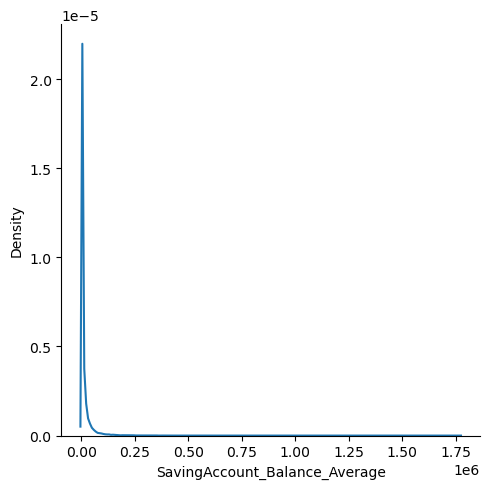

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(customer_universe['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [33]:
# There are a lot of customers that don't use the Saving Account. We need to focus into those who do use it.

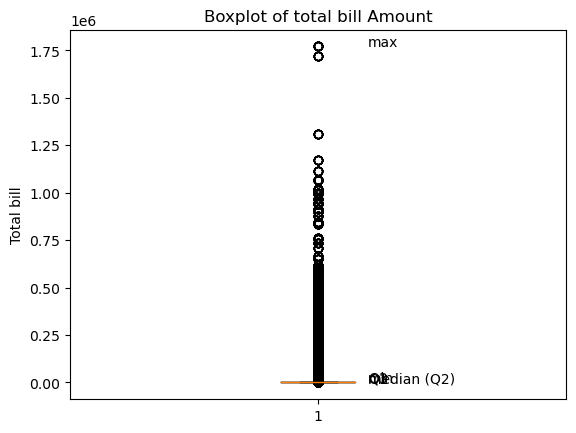

In [34]:
plt.boxplot(customer_universe['SavingAccount_Balance_Average'])

# add labels for five number summary
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].min(), s='min')
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.25), s='Q1')
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].median(), s='median (Q2)')
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.75), s='Q3')
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].max(), s='max')

plt.title('Boxplot of total bill Amount')
plt.ylabel('Total bill')

plt.show()

##### In the above graph, we can see the strong influence of the zeroes. In order to analyze better we need to filter the zeroes and the low values

In [47]:
#Saving Accounts with balance >0 in order to focus in those customers that really use their accounts

saving_accounts_positive = customer_universe[customer_universe.SavingAccount_Balance_Average > 1000]
print('Registries with Savings Account positive')
print(saving_accounts_positive.shape)

Registries with Savings Account positive
(546336, 64)


In [48]:
customer_universe[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,1.878471e+06
mean,4.223915e+03
std,2.278526e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.062000e+01
75%,1.484320e+03
max,1.771201e+06


##### From the table above, we can see that quantile 0.25 has Zero in their account

In [49]:
saving_accounts_positive[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,5.463360e+05
mean,1.428377e+04
std,4.052454e+04
min,1.000010e+03
25%,1.995475e+03
50%,4.165715e+03
75%,1.112809e+04
max,1.771201e+06


C:\Users\santi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


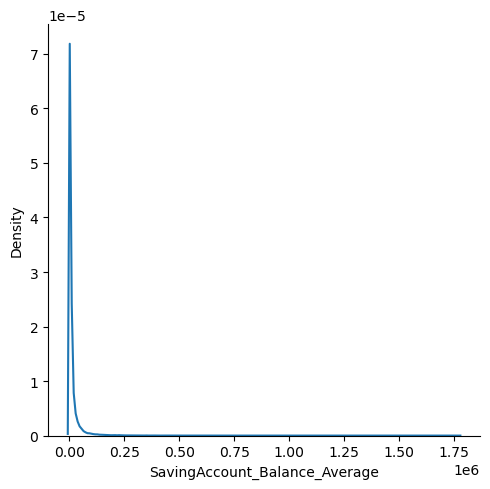

In [50]:

# plot a distribution plot
sns.displot(saving_accounts_positive['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()